In [1]:
'''
XGBOOST module

the module can be use for both classification and regression problem the appropriate objective method should be defined.
more information can be find here
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

User can define a customized objective function and evaluation function

optimization with grid search is easy first make a grid

make_grid(eta = [1, 2, 3], max_depth = [3, 4, 5])

then run the optimization
optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2)

to see the result and select best parameters
scores()


get the importance features and plot them is another awesome part of this module :)

get_importance()
plot_importance()


'''
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

class XGBoost(object):
    def __init__(self, num_boost_round=10, objective=None, feval=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if objective:
            print("Built a XGBoost with defiend objective")
            if feval:
                if type(feval).__name__ == 'str':
                    print("Use eval_metric: ", feval)
                    self.params.update({'objective' : objective, 'eval_metric' : feval, 'silent' : True})
                else:
                    print("Use defiend funcation for eval")
                    self.params.update({'objective' : objective, 'silent' : True})
            else:
                print("Use default eval_metric")
                self.params.update({'objective' : objective, 'silent' : True})
                
        else:
            print("Built a XGBoost with default objective reg:linear")
            self.params.update({'objective' : 'reg:linear', 'silent' : True})

    def evalerror(self, preds, dtrain):
        labels = dtrain.get_label()
        return 'error', self.feval(labels, preds)

    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)

    def fit_eval(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        dtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [(dtrain, 'train'), (dtest, 'eval')]
        
        if type(self.feval).__name__ == 'str' or self.feval == None:
            self.clf = xgb.train(params = self.params, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        else:
            self.clf = xgb.train(params = self.params, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, feval = self.evalerror, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def score(self, X, y):
        Y = self.predict(X)
        return self.feval(y, Y)

    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        return self.clf.get_fscore()

    def plot_importance(self, N = 10):
        importance = self.clf.get_fscore()

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()

    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print(self.grid_list)
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        dtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [(dtrain, 'train'), (dtest, 'eval')]

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in range(len(self.grid_list)):
            temp = {}
            for j, key in enumerate(self.grid_params.keys()):
                temp[key] = self.grid_list[i][j]
            print(temp)
            temp.update(self.params)
#            print(temp)

            if type(self.feval).__name__ == 'str' or self.feval == None:
                self.clf = xgb.train(params = temp, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
            else:
                self.clf = xgb.train(params = temp, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, feval = self.evalerror, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)

            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [self.clf.best_iteration, self.clf.best_score]], columns=col))


    def scores(self):
        return self.result.sort_values("score")

# test the module

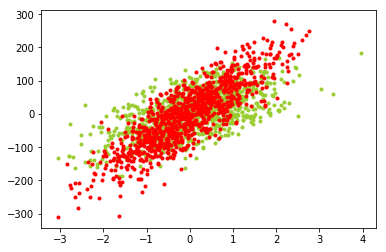

In [3]:
# create a dataset for regression problem
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=1)

X1, y1, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=0)

plt.scatter(X, y, color='yellowgreen', marker='.',
            label='Inliers')
#plt.show()

plt.scatter(X1, y1, color='red', marker='.',
            label='Inliers')
plt.show()

In [5]:
model = XGBoost(objective = "reg:linear")

Built a XGBoost with defiend objective
Use default eval_metric


In [6]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
[[0.01, 4], [0.01, 5], [0.01, 6], [0.02, 4], [0.02, 5], [0.02, 6], [0.03, 4], [0.03, 5], [0.03, 6]]


In [7]:
model.optimization(X, y, X1, y1, verbose_eval = 10, num_boost_round = 200, early_stopping = 20)

{'eta': 0.01, 'max_depth': 4}
[0]	train-rmse:62.0188	eval-rmse:94.5886
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:59.7985	eval-rmse:91.7521
[20]	train-rmse:57.9054	eval-rmse:89.2225
[30]	train-rmse:56.2933	eval-rmse:86.9605
[40]	train-rmse:54.9174	eval-rmse:84.9339
[50]	train-rmse:53.7424	eval-rmse:83.1376
[60]	train-rmse:52.7414	eval-rmse:81.5235
[70]	train-rmse:51.8941	eval-rmse:80.0854
[80]	train-rmse:51.1678	eval-rmse:78.8225
[90]	train-rmse:50.5423	eval-rmse:77.6965
[100]	train-rmse:50.0185	eval-rmse:76.69
[110]	train-rmse:49.5721	eval-rmse:75.7928
[120]	train-rmse:49.1866	eval-rmse:74.9844
[130]	train-rmse:48.8346	eval-rmse:74.2701
[140]	train-rmse:48.5167	eval-rmse:73.6301
[150]	train-rmse:48.2411	eval-rmse:73.061
[160]	train-rmse:48.0063	eval-rmse:72.5563
[170]	train-rmse:47.7869	eval-rmse:72.1034
[180]	train-rmse:47.5966	eval-rmse:71.703
[190]	train-rmse:47.4191	

[140]	train-rmse:43.0753	eval-rmse:68.5895
[150]	train-rmse:42.9108	eval-rmse:68.5476
[160]	train-rmse:42.7499	eval-rmse:68.5196
[170]	train-rmse:42.5822	eval-rmse:68.4961
[180]	train-rmse:42.4384	eval-rmse:68.4859
[190]	train-rmse:42.2769	eval-rmse:68.4778
[199]	train-rmse:42.1079	eval-rmse:68.4621
{'eta': 0.03, 'max_depth': 6}
[0]	train-rmse:61.4675	eval-rmse:93.9894
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:55.1798	eval-rmse:86.6394
[20]	train-rmse:51.0564	eval-rmse:81.4487
[30]	train-rmse:48.3314	eval-rmse:77.7241
[40]	train-rmse:46.4021	eval-rmse:75.208
[50]	train-rmse:45.0407	eval-rmse:73.4176
[60]	train-rmse:44.0734	eval-rmse:72.1321
[70]	train-rmse:43.3536	eval-rmse:71.1453
[80]	train-rmse:42.8557	eval-rmse:70.445
[90]	train-rmse:42.3277	eval-rmse:69.9388
[100]	train-rmse:41.8668	eval-rmse:69.6189
[110]	train-rmse:41.3656	eval-rmse:69.3966
[120]	train-rmse:40.967

In [8]:
model.scores()

,eta,max_depth,iterations,score
0,0.03,4,185,68.365082
0,0.03,5,198,68.460945
0,0.02,4,199,68.480789
0,0.02,5,199,68.639420
0,0.03,6,173,69.019150
0,0.02,6,199,69.078171
0,0.01,4,199,71.022797
0,0.01,5,199,71.242783
0,0.01,6,199,71.536232


# define eval function

In [11]:
from sklearn.metrics import r2_score
model = XGBoost(objective = "reg:linear", feval = lambda x, y: -1 * r2_score(x,y)) # xgboost reduce the error

Built a XGBoost with defiend objective
Use defiend funcation for eval


In [12]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
[[0.01, 4], [0.01, 5], [0.01, 6], [0.02, 4], [0.02, 5], [0.02, 6], [0.03, 4], [0.03, 5], [0.03, 6]]


In [13]:
model.optimization(X, y, X1, y1, verbose_eval = 10, num_boost_round = 200, early_stopping = 20)

{'eta': 0.01, 'max_depth': 4}
[0]	train-rmse:62.0188	eval-rmse:94.5886	train-error:-0.006162	eval-error:-0.005341
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:59.7985	eval-rmse:91.7521	train-error:-0.076046	eval-error:-0.064103
[20]	train-rmse:57.9054	eval-rmse:89.2225	train-error:-0.133623	eval-error:-0.114995
[30]	train-rmse:56.2933	eval-rmse:86.9605	train-error:-0.18119	eval-error:-0.1593
[40]	train-rmse:54.9174	eval-rmse:84.9339	train-error:-0.220729	eval-error:-0.198028
[50]	train-rmse:53.7424	eval-rmse:83.1376	train-error:-0.253716	eval-error:-0.231592
[60]	train-rmse:52.7414	eval-rmse:81.5235	train-error:-0.281258	eval-error:-0.26114
[70]	train-rmse:51.8941	eval-rmse:80.0854	train-error:-0.304168	eval-error:-0.286977
[80]	train-rmse:51.1678	eval-rmse:78.8225	train-error:-0.323507	eval-error:-0.309287
[90]	train-rmse:50.5423	eval-rmse:77.6965	train-error:-0.339946	e

[30]	train-rmse:51.9584	eval-rmse:81.5344	train-error:-0.302441	eval-error:-0.260941
[40]	train-rmse:50.2021	eval-rmse:78.8774	train-error:-0.348801	eval-error:-0.308325
[50]	train-rmse:48.8942	eval-rmse:76.8282	train-error:-0.38229	eval-error:-0.343797
[60]	train-rmse:47.8912	eval-rmse:75.1874	train-error:-0.407374	eval-error:-0.371526
[70]	train-rmse:47.1282	eval-rmse:73.7942	train-error:-0.426107	eval-error:-0.394601
[80]	train-rmse:46.5106	eval-rmse:72.681	train-error:-0.44105	eval-error:-0.41273
[90]	train-rmse:46.0118	eval-rmse:71.8288	train-error:-0.452973	eval-error:-0.42642
[100]	train-rmse:45.615	eval-rmse:71.1631	train-error:-0.462369	eval-error:-0.437003
[110]	train-rmse:45.2798	eval-rmse:70.6172	train-error:-0.470242	eval-error:-0.445607
[120]	train-rmse:44.9573	eval-rmse:70.1433	train-error:-0.477761	eval-error:-0.453023
[130]	train-rmse:44.6658	eval-rmse:69.753	train-error:-0.48451	eval-error:-0.459094
[140]	train-rmse:44.4038	eval-rmse:69.4399	train-error:-0.490542	eval

[80]	train-rmse:42.8557	eval-rmse:70.445	train-error:-0.525445	eval-error:-0.448307
[90]	train-rmse:42.3277	eval-rmse:69.9388	train-error:-0.537067	eval-error:-0.456208
[100]	train-rmse:41.8668	eval-rmse:69.6189	train-error:-0.547094	eval-error:-0.461171
[110]	train-rmse:41.3656	eval-rmse:69.3966	train-error:-0.557873	eval-error:-0.464607
[120]	train-rmse:40.9671	eval-rmse:69.2507	train-error:-0.56635	eval-error:-0.466855
[130]	train-rmse:40.5958	eval-rmse:69.1319	train-error:-0.574175	eval-error:-0.468683
[140]	train-rmse:40.3159	eval-rmse:69.0805	train-error:-0.580027	eval-error:-0.469473
[150]	train-rmse:40.0648	eval-rmse:69.0483	train-error:-0.585241	eval-error:-0.469968
[160]	train-rmse:39.8345	eval-rmse:69.055	train-error:-0.589995	eval-error:-0.469864
[170]	train-rmse:39.6018	eval-rmse:69.0385	train-error:-0.594773	eval-error:-0.470118
[180]	train-rmse:39.4218	eval-rmse:69.0364	train-error:-0.598448	eval-error:-0.470151
[190]	train-rmse:39.2243	eval-rmse:69.0351	train-error:-0.6

In [14]:
model.scores()

,eta,max_depth,iterations,score
0,0.03,4,185,-0.480405
0,0.03,5,198,-0.478946
0,0.02,4,199,-0.478644
0,0.02,5,199,-0.476226
0,0.03,6,173,-0.470415
0,0.02,6,199,-0.469509
0,0.01,4,199,-0.439220
0,0.01,5,199,-0.435741
0,0.01,6,199,-0.431083


In [101]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
model = XGBoost(objective = "reg:linear", feval = lambda x, y: -1 * r2_score(x,y))

Built a XGBoost with defiend objective
Use defiend funcation for eval


In [102]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
[[0.01, 4], [0.01, 5], [0.01, 6], [0.02, 4], [0.02, 5], [0.02, 6], [0.03, 4], [0.03, 5], [0.03, 6]]


In [105]:
model.optimization(X, y, X1, y1, verbose_eval = 1, num_boost_round = 200, early_stopping = 20)

{'eta': 0.01, 'max_depth': 4}
[0]	train-rmse:62.0188	eval-rmse:94.5886	train-error:-0.006162	eval-error:-0.005341
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[1]	train-rmse:61.7822	eval-rmse:94.2925	train-error:-0.01373	eval-error:-0.011559
[2]	train-rmse:61.5476	eval-rmse:93.9985	train-error:-0.021207	eval-error:-0.017712
[3]	train-rmse:61.3164	eval-rmse:93.7088	train-error:-0.028545	eval-error:-0.023757
[4]	train-rmse:61.0887	eval-rmse:93.421	train-error:-0.035748	eval-error:-0.029746
[5]	train-rmse:60.8646	eval-rmse:93.138	train-error:-0.042807	eval-error:-0.035615
[6]	train-rmse:60.6446	eval-rmse:92.8522	train-error:-0.049715	eval-error:-0.041525
[7]	train-rmse:60.4275	eval-rmse:92.5757	train-error:-0.056506	eval-error:-0.047224
[8]	train-rmse:60.2157	eval-rmse:92.296	train-error:-0.063108	eval-error:-0.052972
[9]	train-rmse:60.0054	eval-rmse:92.0259	train-error:-0.069642	eval-error

[96]	train-rmse:50.2172	eval-rmse:77.0795	train-error:-0.348411	eval-error:-0.339498
[97]	train-rmse:50.1669	eval-rmse:76.981	train-error:-0.349714	eval-error:-0.341185
[98]	train-rmse:50.1171	eval-rmse:76.8814	train-error:-0.351004	eval-error:-0.342889
[99]	train-rmse:50.0685	eval-rmse:76.7851	train-error:-0.352263	eval-error:-0.344534
[100]	train-rmse:50.0185	eval-rmse:76.69	train-error:-0.353557	eval-error:-0.346157
[101]	train-rmse:49.9714	eval-rmse:76.5958	train-error:-0.354772	eval-error:-0.347761
[102]	train-rmse:49.923	eval-rmse:76.5028	train-error:-0.356023	eval-error:-0.349344
[103]	train-rmse:49.8774	eval-rmse:76.4108	train-error:-0.357198	eval-error:-0.350909
[104]	train-rmse:49.8304	eval-rmse:76.3186	train-error:-0.35841	eval-error:-0.352474
[105]	train-rmse:49.7856	eval-rmse:76.2282	train-error:-0.359562	eval-error:-0.354006
[106]	train-rmse:49.7421	eval-rmse:76.1392	train-error:-0.36068	eval-error:-0.355515
[107]	train-rmse:49.6994	eval-rmse:76.0514	train-error:-0.361778

[192]	train-rmse:47.3871	eval-rmse:71.2545	train-error:-0.419784	eval-error:-0.435556
[193]	train-rmse:47.3688	eval-rmse:71.2197	train-error:-0.420232	eval-error:-0.436106
[194]	train-rmse:47.3541	eval-rmse:71.185	train-error:-0.420591	eval-error:-0.436655
[195]	train-rmse:47.3373	eval-rmse:71.1508	train-error:-0.421002	eval-error:-0.437197
[196]	train-rmse:47.3209	eval-rmse:71.1191	train-error:-0.421405	eval-error:-0.437698
[197]	train-rmse:47.3032	eval-rmse:71.0863	train-error:-0.421836	eval-error:-0.438217
[198]	train-rmse:47.2871	eval-rmse:71.0556	train-error:-0.422231	eval-error:-0.438702
[199]	train-rmse:47.27	eval-rmse:71.0228	train-error:-0.422648	eval-error:-0.43922
{'eta': 0.01, 'max_depth': 5}
[0]	train-rmse:62.0077	eval-rmse:94.5869	train-error:-0.006518	eval-error:-0.005376
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[1]	train-rmse:61.7617	eval-rmse:94.2905	train-error:-0.0

[87]	train-rmse:49.7919	eval-rmse:78.253	train-error:-0.359399	eval-error:-0.319234
[88]	train-rmse:49.7222	eval-rmse:78.144	train-error:-0.361191	eval-error:-0.321128
[89]	train-rmse:49.6559	eval-rmse:78.0378	train-error:-0.362896	eval-error:-0.322973
[90]	train-rmse:49.5882	eval-rmse:77.9313	train-error:-0.364631	eval-error:-0.324819
[91]	train-rmse:49.5216	eval-rmse:77.8261	train-error:-0.366335	eval-error:-0.326641
[92]	train-rmse:49.4577	eval-rmse:77.7284	train-error:-0.367971	eval-error:-0.32833
[93]	train-rmse:49.3932	eval-rmse:77.6284	train-error:-0.369619	eval-error:-0.330058
[94]	train-rmse:49.3282	eval-rmse:77.5288	train-error:-0.371277	eval-error:-0.331775
[95]	train-rmse:49.2695	eval-rmse:77.4349	train-error:-0.372771	eval-error:-0.333393
[96]	train-rmse:49.2066	eval-rmse:77.3385	train-error:-0.374371	eval-error:-0.335051
[97]	train-rmse:49.1452	eval-rmse:77.2431	train-error:-0.375932	eval-error:-0.33669
[98]	train-rmse:49.0863	eval-rmse:77.148	train-error:-0.377428	eval-e

[183]	train-rmse:46.006	eval-rmse:71.7881	train-error:-0.453111	eval-error:-0.427071
[184]	train-rmse:45.9857	eval-rmse:71.754	train-error:-0.453595	eval-error:-0.427614
[185]	train-rmse:45.9634	eval-rmse:71.716	train-error:-0.454124	eval-error:-0.428221
[186]	train-rmse:45.944	eval-rmse:71.6809	train-error:-0.454586	eval-error:-0.428779
[187]	train-rmse:45.9213	eval-rmse:71.6424	train-error:-0.455123	eval-error:-0.429393
[188]	train-rmse:45.8996	eval-rmse:71.6058	train-error:-0.455639	eval-error:-0.429976
[189]	train-rmse:45.8802	eval-rmse:71.5708	train-error:-0.4561	eval-error:-0.430534
[190]	train-rmse:45.8591	eval-rmse:71.5348	train-error:-0.4566	eval-error:-0.431107
[191]	train-rmse:45.8396	eval-rmse:71.5023	train-error:-0.457061	eval-error:-0.431623
[192]	train-rmse:45.8186	eval-rmse:71.4696	train-error:-0.457559	eval-error:-0.432142
[193]	train-rmse:45.8005	eval-rmse:71.4385	train-error:-0.457987	eval-error:-0.432637
[194]	train-rmse:45.7802	eval-rmse:71.4022	train-error:-0.4584

[79]	train-rmse:49.4545	eval-rmse:79.2262	train-error:-0.368054	eval-error:-0.302194
[80]	train-rmse:49.3682	eval-rmse:79.1082	train-error:-0.370256	eval-error:-0.304272
[81]	train-rmse:49.2776	eval-rmse:78.9855	train-error:-0.372565	eval-error:-0.306429
[82]	train-rmse:49.1973	eval-rmse:78.8738	train-error:-0.374609	eval-error:-0.308389
[83]	train-rmse:49.1187	eval-rmse:78.7648	train-error:-0.376606	eval-error:-0.310298
[84]	train-rmse:49.0322	eval-rmse:78.6494	train-error:-0.378799	eval-error:-0.312319
[85]	train-rmse:48.9551	eval-rmse:78.5418	train-error:-0.380752	eval-error:-0.314198
[86]	train-rmse:48.8733	eval-rmse:78.4344	train-error:-0.38282	eval-error:-0.316073
[87]	train-rmse:48.7872	eval-rmse:78.3277	train-error:-0.384992	eval-error:-0.317932
[88]	train-rmse:48.7046	eval-rmse:78.2168	train-error:-0.387072	eval-error:-0.319863
[89]	train-rmse:48.6315	eval-rmse:78.1148	train-error:-0.38891	eval-error:-0.321635
[90]	train-rmse:48.5513	eval-rmse:78.0062	train-error:-0.390923	eva

[175]	train-rmse:44.371	eval-rmse:72.4106	train-error:-0.491292	eval-error:-0.41709
[176]	train-rmse:44.3455	eval-rmse:72.367	train-error:-0.491877	eval-error:-0.417793
[177]	train-rmse:44.3192	eval-rmse:72.3258	train-error:-0.492481	eval-error:-0.418456
[178]	train-rmse:44.2901	eval-rmse:72.2867	train-error:-0.493147	eval-error:-0.419083
[179]	train-rmse:44.2645	eval-rmse:72.2453	train-error:-0.493731	eval-error:-0.419749
[180]	train-rmse:44.2401	eval-rmse:72.2049	train-error:-0.494291	eval-error:-0.420398
[181]	train-rmse:44.2139	eval-rmse:72.1667	train-error:-0.494889	eval-error:-0.421011
[182]	train-rmse:44.1877	eval-rmse:72.1283	train-error:-0.495487	eval-error:-0.421626
[183]	train-rmse:44.1581	eval-rmse:72.0925	train-error:-0.496162	eval-error:-0.422201
[184]	train-rmse:44.1349	eval-rmse:72.0529	train-error:-0.496693	eval-error:-0.422836
[185]	train-rmse:44.1047	eval-rmse:72.0167	train-error:-0.497381	eval-error:-0.423415
[186]	train-rmse:44.0805	eval-rmse:71.9804	train-error:-0

[70]	train-rmse:48.4768	eval-rmse:73.5247	train-error:-0.392793	eval-error:-0.399015
[71]	train-rmse:48.4092	eval-rmse:73.402	train-error:-0.394484	eval-error:-0.401019
[72]	train-rmse:48.3593	eval-rmse:73.2872	train-error:-0.395731	eval-error:-0.402892
[73]	train-rmse:48.303	eval-rmse:73.1767	train-error:-0.397137	eval-error:-0.404691
[74]	train-rmse:48.2401	eval-rmse:73.0624	train-error:-0.398708	eval-error:-0.40655
[75]	train-rmse:48.1943	eval-rmse:72.964	train-error:-0.399848	eval-error:-0.408147
[76]	train-rmse:48.1435	eval-rmse:72.8508	train-error:-0.401112	eval-error:-0.409982
[77]	train-rmse:48.0847	eval-rmse:72.7435	train-error:-0.402575	eval-error:-0.411718
[78]	train-rmse:48.0337	eval-rmse:72.6504	train-error:-0.403842	eval-error:-0.413224
[79]	train-rmse:47.9901	eval-rmse:72.5479	train-error:-0.404923	eval-error:-0.414879
[80]	train-rmse:47.9495	eval-rmse:72.4509	train-error:-0.40593	eval-error:-0.416442
[81]	train-rmse:47.9097	eval-rmse:72.361	train-error:-0.406916	eval-er

[167]	train-rmse:45.679	eval-rmse:68.8205	train-error:-0.460859	eval-error:-0.473458
[168]	train-rmse:45.6647	eval-rmse:68.8047	train-error:-0.461197	eval-error:-0.4737
[169]	train-rmse:45.6468	eval-rmse:68.7924	train-error:-0.461619	eval-error:-0.473889
[170]	train-rmse:45.6378	eval-rmse:68.7787	train-error:-0.46183	eval-error:-0.474099
[171]	train-rmse:45.6157	eval-rmse:68.7645	train-error:-0.462351	eval-error:-0.474316
[172]	train-rmse:45.607	eval-rmse:68.7511	train-error:-0.462556	eval-error:-0.47452
[173]	train-rmse:45.5922	eval-rmse:68.7347	train-error:-0.462905	eval-error:-0.474772
[174]	train-rmse:45.5745	eval-rmse:68.7192	train-error:-0.463323	eval-error:-0.475008
[175]	train-rmse:45.558	eval-rmse:68.7131	train-error:-0.46371	eval-error:-0.475101
[176]	train-rmse:45.5496	eval-rmse:68.6946	train-error:-0.463909	eval-error:-0.475384
[177]	train-rmse:45.5383	eval-rmse:68.6791	train-error:-0.464174	eval-error:-0.475621
[178]	train-rmse:45.5206	eval-rmse:68.6716	train-error:-0.4645

[62]	train-rmse:47.7181	eval-rmse:74.8815	train-error:-0.411651	eval-error:-0.376631
[63]	train-rmse:47.6318	eval-rmse:74.7412	train-error:-0.413776	eval-error:-0.378964
[64]	train-rmse:47.5518	eval-rmse:74.6027	train-error:-0.415744	eval-error:-0.381264
[65]	train-rmse:47.4753	eval-rmse:74.4595	train-error:-0.417622	eval-error:-0.383636
[66]	train-rmse:47.3998	eval-rmse:74.3151	train-error:-0.419473	eval-error:-0.386025
[67]	train-rmse:47.3256	eval-rmse:74.1848	train-error:-0.42129	eval-error:-0.388176
[68]	train-rmse:47.2555	eval-rmse:74.051	train-error:-0.423003	eval-error:-0.39038
[69]	train-rmse:47.1882	eval-rmse:73.9245	train-error:-0.424645	eval-error:-0.392461
[70]	train-rmse:47.1282	eval-rmse:73.7942	train-error:-0.426107	eval-error:-0.394601
[71]	train-rmse:47.0609	eval-rmse:73.6676	train-error:-0.427745	eval-error:-0.396677
[72]	train-rmse:46.9972	eval-rmse:73.5604	train-error:-0.429294	eval-error:-0.398432
[73]	train-rmse:46.9419	eval-rmse:73.4433	train-error:-0.430636	eval

[159]	train-rmse:43.996	eval-rmse:69.052	train-error:-0.499855	eval-error:-0.469911
[160]	train-rmse:43.9688	eval-rmse:69.0347	train-error:-0.500473	eval-error:-0.470176
[161]	train-rmse:43.9553	eval-rmse:69.0203	train-error:-0.50078	eval-error:-0.470397
[162]	train-rmse:43.9289	eval-rmse:69.0037	train-error:-0.50138	eval-error:-0.470651
[163]	train-rmse:43.897	eval-rmse:68.9868	train-error:-0.502103	eval-error:-0.470911
[164]	train-rmse:43.8761	eval-rmse:68.9664	train-error:-0.502577	eval-error:-0.471225
[165]	train-rmse:43.8545	eval-rmse:68.9563	train-error:-0.503068	eval-error:-0.471379
[166]	train-rmse:43.8237	eval-rmse:68.9407	train-error:-0.503765	eval-error:-0.471619
[167]	train-rmse:43.8053	eval-rmse:68.9188	train-error:-0.504181	eval-error:-0.471953
[168]	train-rmse:43.7816	eval-rmse:68.9083	train-error:-0.504719	eval-error:-0.472114
[169]	train-rmse:43.7565	eval-rmse:68.893	train-error:-0.505285	eval-error:-0.472349
[170]	train-rmse:43.7403	eval-rmse:68.8741	train-error:-0.50

[54]	train-rmse:47.2007	eval-rmse:76.2223	train-error:-0.424339	eval-error:-0.354106
[55]	train-rmse:47.0768	eval-rmse:76.0571	train-error:-0.427359	eval-error:-0.356904
[56]	train-rmse:46.9653	eval-rmse:75.9016	train-error:-0.430068	eval-error:-0.35953
[57]	train-rmse:46.8523	eval-rmse:75.7428	train-error:-0.432806	eval-error:-0.362208
[58]	train-rmse:46.7377	eval-rmse:75.5894	train-error:-0.435578	eval-error:-0.364789
[59]	train-rmse:46.6293	eval-rmse:75.4473	train-error:-0.438193	eval-error:-0.367174
[60]	train-rmse:46.5168	eval-rmse:75.2961	train-error:-0.440901	eval-error:-0.369708
[61]	train-rmse:46.418	eval-rmse:75.1591	train-error:-0.443272	eval-error:-0.371999
[62]	train-rmse:46.3048	eval-rmse:75.0246	train-error:-0.445985	eval-error:-0.374245
[63]	train-rmse:46.1964	eval-rmse:74.8998	train-error:-0.448575	eval-error:-0.376325
[64]	train-rmse:46.0878	eval-rmse:74.7737	train-error:-0.451165	eval-error:-0.378423
[65]	train-rmse:45.9911	eval-rmse:74.6476	train-error:-0.453466	eva

[151]	train-rmse:41.8453	eval-rmse:69.5819	train-error:-0.547559	eval-error:-0.461744
[152]	train-rmse:41.8046	eval-rmse:69.5682	train-error:-0.548437	eval-error:-0.461955
[153]	train-rmse:41.7635	eval-rmse:69.5538	train-error:-0.549325	eval-error:-0.462179
[154]	train-rmse:41.7373	eval-rmse:69.5327	train-error:-0.549891	eval-error:-0.462504
[155]	train-rmse:41.7083	eval-rmse:69.5195	train-error:-0.550516	eval-error:-0.462709
[156]	train-rmse:41.6642	eval-rmse:69.5083	train-error:-0.551465	eval-error:-0.462882
[157]	train-rmse:41.6327	eval-rmse:69.4872	train-error:-0.552145	eval-error:-0.463208
[158]	train-rmse:41.5921	eval-rmse:69.4698	train-error:-0.553017	eval-error:-0.463477
[159]	train-rmse:41.5615	eval-rmse:69.4654	train-error:-0.553674	eval-error:-0.463545
[160]	train-rmse:41.5311	eval-rmse:69.4451	train-error:-0.554328	eval-error:-0.463859
[161]	train-rmse:41.5031	eval-rmse:69.4338	train-error:-0.554928	eval-error:-0.464032
[162]	train-rmse:41.4694	eval-rmse:69.4225	train-error

[46]	train-rmse:48.4695	eval-rmse:73.5296	train-error:-0.392976	eval-error:-0.398936
[47]	train-rmse:48.3699	eval-rmse:73.3466	train-error:-0.395466	eval-error:-0.401923
[48]	train-rmse:48.295	eval-rmse:73.1845	train-error:-0.397339	eval-error:-0.404565
[49]	train-rmse:48.2222	eval-rmse:73.0144	train-error:-0.399153	eval-error:-0.407329
[50]	train-rmse:48.1394	eval-rmse:72.8611	train-error:-0.401216	eval-error:-0.409815
[51]	train-rmse:48.0618	eval-rmse:72.7138	train-error:-0.403144	eval-error:-0.412199
[52]	train-rmse:47.9768	eval-rmse:72.5625	train-error:-0.405252	eval-error:-0.414643
[53]	train-rmse:47.9169	eval-rmse:72.4223	train-error:-0.406737	eval-error:-0.416902
[54]	train-rmse:47.8379	eval-rmse:72.2771	train-error:-0.408691	eval-error:-0.419238
[55]	train-rmse:47.7757	eval-rmse:72.1401	train-error:-0.410228	eval-error:-0.421437
[56]	train-rmse:47.715	eval-rmse:72.0233	train-error:-0.411728	eval-error:-0.42331
[57]	train-rmse:47.657	eval-rmse:71.8877	train-error:-0.413155	eval-

[143]	train-rmse:45.0539	eval-rmse:68.4459	train-error:-0.475514	eval-error:-0.479176
[144]	train-rmse:45.0218	eval-rmse:68.4311	train-error:-0.476261	eval-error:-0.479401
[145]	train-rmse:44.9915	eval-rmse:68.4211	train-error:-0.476965	eval-error:-0.479552
[146]	train-rmse:44.9849	eval-rmse:68.4178	train-error:-0.477119	eval-error:-0.479603
[147]	train-rmse:44.974	eval-rmse:68.4252	train-error:-0.477372	eval-error:-0.47949
[148]	train-rmse:44.9484	eval-rmse:68.4184	train-error:-0.477967	eval-error:-0.479594
[149]	train-rmse:44.9341	eval-rmse:68.4202	train-error:-0.478299	eval-error:-0.479566
[150]	train-rmse:44.9099	eval-rmse:68.4187	train-error:-0.478862	eval-error:-0.479589
[151]	train-rmse:44.8978	eval-rmse:68.4155	train-error:-0.479142	eval-error:-0.479638
[152]	train-rmse:44.8772	eval-rmse:68.4011	train-error:-0.47962	eval-error:-0.479857
[153]	train-rmse:44.8667	eval-rmse:68.4086	train-error:-0.479863	eval-error:-0.479742
[154]	train-rmse:44.85	eval-rmse:68.4211	train-error:-0.4

[38]	train-rmse:48.0963	eval-rmse:75.525	train-error:-0.402286	eval-error:-0.365871
[39]	train-rmse:47.9596	eval-rmse:75.2895	train-error:-0.405679	eval-error:-0.369818
[40]	train-rmse:47.8174	eval-rmse:75.0425	train-error:-0.409198	eval-error:-0.373947
[41]	train-rmse:47.6868	eval-rmse:74.8254	train-error:-0.412421	eval-error:-0.377563
[42]	train-rmse:47.571	eval-rmse:74.6343	train-error:-0.415271	eval-error:-0.380739
[43]	train-rmse:47.4537	eval-rmse:74.4219	train-error:-0.418152	eval-error:-0.384259
[44]	train-rmse:47.3412	eval-rmse:74.2244	train-error:-0.420907	eval-error:-0.387523
[45]	train-rmse:47.228	eval-rmse:74.0177	train-error:-0.423675	eval-error:-0.39093
[46]	train-rmse:47.1215	eval-rmse:73.8244	train-error:-0.426269	eval-error:-0.394105
[47]	train-rmse:47.0219	eval-rmse:73.6411	train-error:-0.428694	eval-error:-0.397112
[48]	train-rmse:46.923	eval-rmse:73.4686	train-error:-0.431094	eval-error:-0.399932
[49]	train-rmse:46.8269	eval-rmse:73.2964	train-error:-0.43342	eval-er

[135]	train-rmse:43.1929	eval-rmse:68.6089	train-error:-0.517948	eval-error:-0.476691
[136]	train-rmse:43.1683	eval-rmse:68.6025	train-error:-0.518496	eval-error:-0.476789
[137]	train-rmse:43.1543	eval-rmse:68.6005	train-error:-0.518809	eval-error:-0.476819
[138]	train-rmse:43.1227	eval-rmse:68.595	train-error:-0.519513	eval-error:-0.476904
[139]	train-rmse:43.0933	eval-rmse:68.5865	train-error:-0.520169	eval-error:-0.477034
[140]	train-rmse:43.0753	eval-rmse:68.5895	train-error:-0.520568	eval-error:-0.476987
[141]	train-rmse:43.0618	eval-rmse:68.5879	train-error:-0.520869	eval-error:-0.477013
[142]	train-rmse:43.0523	eval-rmse:68.5861	train-error:-0.52108	eval-error:-0.477039
[143]	train-rmse:43.0393	eval-rmse:68.5847	train-error:-0.521371	eval-error:-0.477061
[144]	train-rmse:43.0118	eval-rmse:68.5779	train-error:-0.521982	eval-error:-0.477164
[145]	train-rmse:43.0026	eval-rmse:68.5764	train-error:-0.522186	eval-error:-0.477187
[146]	train-rmse:42.99	eval-rmse:68.5752	train-error:-0.

[30]	train-rmse:48.3314	eval-rmse:77.7241	train-error:-0.396429	eval-error:-0.328404
[31]	train-rmse:48.1087	eval-rmse:77.4253	train-error:-0.401978	eval-error:-0.333558
[32]	train-rmse:47.891	eval-rmse:77.1424	train-error:-0.40738	eval-error:-0.338419
[33]	train-rmse:47.6802	eval-rmse:76.852	train-error:-0.412584	eval-error:-0.34339
[34]	train-rmse:47.4865	eval-rmse:76.6001	train-error:-0.417348	eval-error:-0.347689
[35]	train-rmse:47.2956	eval-rmse:76.3364	train-error:-0.422023	eval-error:-0.352171
[36]	train-rmse:47.1094	eval-rmse:76.0949	train-error:-0.426565	eval-error:-0.356265
[37]	train-rmse:46.9269	eval-rmse:75.8634	train-error:-0.431	eval-error:-0.360175
[38]	train-rmse:46.7554	eval-rmse:75.6381	train-error:-0.43515	eval-error:-0.36397
[39]	train-rmse:46.5725	eval-rmse:75.4133	train-error:-0.43956	eval-error:-0.367745
[40]	train-rmse:46.4021	eval-rmse:75.208	train-error:-0.443654	eval-error:-0.371182
[41]	train-rmse:46.2473	eval-rmse:74.9968	train-error:-0.447361	eval-error:-

[127]	train-rmse:40.7099	eval-rmse:69.1588	train-error:-0.571778	eval-error:-0.46827
[128]	train-rmse:40.6851	eval-rmse:69.1604	train-error:-0.572298	eval-error:-0.468245
[129]	train-rmse:40.643	eval-rmse:69.1469	train-error:-0.573184	eval-error:-0.468453
[130]	train-rmse:40.5958	eval-rmse:69.1319	train-error:-0.574175	eval-error:-0.468683
[131]	train-rmse:40.5763	eval-rmse:69.1228	train-error:-0.574584	eval-error:-0.468822
[132]	train-rmse:40.5359	eval-rmse:69.1096	train-error:-0.575429	eval-error:-0.469026
[133]	train-rmse:40.4904	eval-rmse:69.0956	train-error:-0.576382	eval-error:-0.46924
[134]	train-rmse:40.4724	eval-rmse:69.0855	train-error:-0.576759	eval-error:-0.469395
[135]	train-rmse:40.4412	eval-rmse:69.0753	train-error:-0.577412	eval-error:-0.469553
[136]	train-rmse:40.4232	eval-rmse:69.0841	train-error:-0.577787	eval-error:-0.469418
[137]	train-rmse:40.3884	eval-rmse:69.0817	train-error:-0.578515	eval-error:-0.469454
[138]	train-rmse:40.3692	eval-rmse:69.0753	train-error:-0

In [106]:
model.scores()

,eta,max_depth,iterations,score
0,0.03,4,185,-0.480405
0,0.03,5,198,-0.478946
0,0.02,4,199,-0.478644
0,0.02,5,199,-0.476226
0,0.03,6,173,-0.470415
0,0.02,6,199,-0.469509
0,0.01,4,199,-0.439220
0,0.01,5,199,-0.435741
0,0.01,6,199,-0.431083
